In [1]:
import os
import numpy as np
from locscale.include.emmer.pdb.pdb_to_map import detect_pdb_input
from locscale.include.emmer.pdb.pdb_utils import get_gemmi_st_from_id
import gemmi


In [2]:
def get_closest_residue_in_structure(input_residue, target_structure, ns, search_dist=5):
    # Function to get the closest residue in a structure in terms of euclidean distance
    # closest residue is defined as the residue with the closest C-alpha atom
    #ns = gemmi.NeighborSearch(target_structure[0], target_structure.cell, search_dist).populate()

    input_residue_ca = input_residue.find_atom('CA', '*')
    if input_residue_ca is None:
        return "NONE"
    input_residue_pos = input_residue_ca.pos

    neighbors = ns.find_atoms(input_residue_pos, '\0', search_dist)
    if len(neighbors) == 0:
        return "NONE"
    else:
        # find the closes C-alpha atom
        closest_ca_atom = None
        all_ca_atoms = []
        ca_dist = []
        for neighbor in neighbors:
            atom = neighbor.to_cra(target_structure[0]).atom
            if atom.name == 'CA':
                all_ca_atoms.append(neighbor)
                ca_dist.append(atom.pos.dist(input_residue_pos))
        if len(all_ca_atoms) == 0:
            return "NONE"
        else:
            closest_ca_atom = all_ca_atoms[np.argmin(ca_dist)]
            closest_residue = target_structure[0][closest_ca_atom.chain_idx][closest_ca_atom.residue_idx]
            return closest_residue.name

In [3]:
def get_all_residues(structure):
    residue_list = []
    for chain in structure[0]:
        for residue in chain:
            residue_list.append(residue)
    return residue_list

Precision:  0.9495848908402003
Recall:  0.9520377359353329


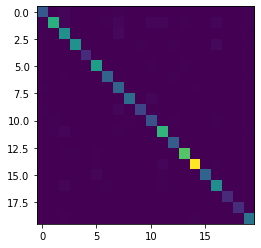

In [4]:
reference_pdb_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/5a63.pdb"
#target_pdb_path = "/home/abharadwaj1/papers/elife_paper/figure_information/inputs/emd_3061/hybrid/modelangelo/emd_3061_hybrid_denovo_MA/emd_3061_hybrid_denovo_MA.cif"
#target_pdb_path = "/home/abharadwaj1/papers/elife_paper/figure_information/inputs/emd_3061/hybrid/modelangelo/emd_3061_unsharpened/emd_3061_unsharpened_MA/emd_3061_unsharpened_MA.cif"
target_pdb_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/hybrid/modelangelo/emd_3061_deposited_denovo_fasta_MA/emd_3061_deposited_denovo_fasta_MA_raw.cif"

# Load the reference structure
reference_structure = gemmi.read_structure(reference_pdb_path)
target_structure = gemmi.read_structure(target_pdb_path)

target_residues = get_all_residues(target_structure)
amino_acids = ['ASN', 'SER', 'GLY', 'ILE', 'MET', 'PHE', 'ASP', 'GLU', 'ARG', 'TRP', 'LYS', 'ALA', 'GLN', 'VAL', 'LEU', 'TYR', 'THR', 'CYS', 'HIS', 'PRO']
filtered_residues_target = [residue for residue in target_residues if residue.name in amino_acids]
ns = gemmi.NeighborSearch(reference_structure[0], reference_structure.cell, 5).populate()
reference_residues = [get_closest_residue_in_structure(target_residue, reference_structure, ns) for target_residue in filtered_residues_target]

indices_of_NONES = [i for i, x in enumerate(reference_residues) if x == "NONE"]
sample_residue_reference_names = [x for i, x in enumerate(reference_residues) if i not in indices_of_NONES]
sample_residue_target_names = [residue.name for i, residue in enumerate(filtered_residues_target) if i not in indices_of_NONES]

from sklearn.metrics import confusion_matrix
heatmap = confusion_matrix(sample_residue_reference_names, sample_residue_target_names, labels=amino_acids)

import matplotlib.pyplot as plt
plt.imshow(heatmap)

from sklearn.metrics import precision_score, recall_score 
precision = precision_score(sample_residue_reference_names, sample_residue_target_names, average='macro', labels=amino_acids)
recall = recall_score(sample_residue_reference_names, sample_residue_target_names, average='macro', labels=amino_acids)

print("Precision: ", precision)
print("Recall: ", recall)




In [5]:
# create a confusion matrix for all the residues in the target structure and the reference structure
# pick random 50 residues from the target structure and find the closest residue in the reference structure
# for each of the 50 residues, find whether the predicted residue name is the same as the reference residue name
# just get a heatmap of the confusion matrix where the x-axis is the reference residue name and the y-axis is the predicted residue name
# the heatmap should be normalized by the total number of residues in the target structure

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import random
def get_confusion_matrix(all_residues_target, all_residues_reference, ns, reference_structure):
    amino_acids = ['ASN', 'SER', 'GLY', 'ILE', 'MET', 'PHE', 'ASP', 'GLU', 'ARG', 'TRP', 'LYS', 'ALA', 'GLN', 'VAL', 'LEU', 'TYR', 'THR', 'CYS', 'HIS', 'PRO']
    filtered_residues_target = [residue for residue in all_residues_target if residue.name in amino_acids]

    min_residues = min(len(filtered_residues_target), len(all_residues_reference))
    sample_size = 500 if min_residues > 500 else min_residues
    
    sample_residue_reference_names = [get_closest_residue_in_structure(residue, reference_structure, ns) for residue in all_residues_target]

    indices_of_NONES = [i for i, x in enumerate(sample_residue_reference_names) if x == "NONE"]
    sample_residue_reference_names = [x for i, x in enumerate(sample_residue_reference_names) if i not in indices_of_NONES]
    sample_residue_target_names = [residue.name for i, residue in enumerate(all_residues_target) if i not in indices_of_NONES]


    labels = amino_acids

    heatmap=confusion_matrix(sample_residue_target_names, sample_residue_reference_names, normalize='pred', labels=labels)
    precision = precision_score(sample_residue_target_names, sample_residue_reference_names, average='macro', labels=labels)
    recall = recall_score(sample_residue_target_names, sample_residue_reference_names, average='macro', labels=labels)


    return heatmap, precision, recall





In [6]:
import sys 
def progress_bar_emoji(iterable, prefix = '', suffix = '', decimals = 1, length = 100):
    """
    Wrap around an iterable to create a terminal progress bar with emoji.

    iterable    - Required  : iterable (Iterable)
    prefix      - Optional  : prefix string (Str)
    suffix      - Optional  : suffix string (Str)
    decimals    - Optional  : positive number of decimals in percent complete (Int)
    length      - Optional  : character length of bar (Int)
    """
    total = len(iterable)
    def print_progress_bar(iteration):
        percent = 100 * (iteration / float(total))
        percent = round(percent, decimals)
        if percent < 10:
            emoji = "😴"  # sleeping face for starting phase
        elif percent < 40:
            emoji = "😃"  # grinning face for early phase
        elif percent < 70:
            emoji = "😄"  # grinning face with smiling eyes for middle phase
        elif percent < 90:
            emoji = "😅"  # grinning face with sweat for later phase
        else:
            emoji = "🥳"  # partying face for nearly complete

        filled_length = int(length * iteration // total)
        bar = "█" * filled_length + str(emoji) + '-' * (length - filled_length)
        sys.stdout.write('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix))
        sys.stdout.flush()

        # Print New Line on Complete
        if iteration == total: 
            print()

    # Initial call to print 0% progress
    print_progress_bar(0)

    for i, item in enumerate(iterable):
        yield item
        print_progress_bar(i + 1)

In [7]:

parent_folder_predictions = "/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version"

confusion_matrix_dict = {}

precision_dict = {}
recall_dict = {}
f1_dict = {}

for emdb_pdb in progress_bar_emoji(os.listdir(parent_folder_predictions)):
    # make sure emdb_pdb is a string
    if not isinstance(emdb_pdb, str):
        continue
    
    if len(emdb_pdb.split("_")) != 2:
        continue

    emdb, pdb = emdb_pdb.split("_")

    emdb_folder = os.path.join(parent_folder_predictions, emdb_pdb)

    # make sure emdb_folder is a folder
    if not os.path.isdir(emdb_folder):
        continue

    model_angelo_predicted_structure_hybrid = os.path.join(emdb_folder, f"emd_{emdb}_model_angelo_hybrid", f"emd_{emdb}_model_angelo_hybrid.cif")
    model_angelo_predicted_structure_unsharpened = os.path.join(emdb_folder, f"emd_{emdb}_model_angelo_unsharpened", f"emd_{emdb}_model_angelo_unsharpened.cif")

    model_angelo_predicted_structure_hybrid_raw = os.path.join(emdb_folder, f"emd_{emdb}_model_angelo_hybrid", f"emd_{emdb}_model_angelo_hybrid_raw.cif")
    model_angelo_predicted_structure_unsharpened_raw = os.path.join(emdb_folder, f"emd_{emdb}_model_angelo_unsharpened", f"emd_{emdb}_model_angelo_unsharpened_raw.cif")

    reference_structure = "/home/abharadwaj1/papers/elife_paper/figure_information/data/deposited_atomic_models/PDB_{}_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb".format(pdb)

    # make sure all files exist
    hybrid_file_exists = os.path.isfile(model_angelo_predicted_structure_hybrid)
    unsharpened_file_exists = os.path.isfile(model_angelo_predicted_structure_unsharpened)

    hybrid_file_exists_raw = os.path.isfile(model_angelo_predicted_structure_hybrid_raw)
    unsharpened_file_exists_raw = os.path.isfile(model_angelo_predicted_structure_unsharpened_raw)

    reference_file_exists = os.path.isfile(reference_structure)
    
    if not hybrid_file_exists or not unsharpened_file_exists or not hybrid_file_exists_raw or not unsharpened_file_exists_raw or not reference_file_exists:
        continue        
    # read in the structures
    hybrid_structure = gemmi.read_structure(model_angelo_predicted_structure_hybrid)
    unsharpened_structure = gemmi.read_structure(model_angelo_predicted_structure_unsharpened)

    hybrid_structure_raw = gemmi.read_structure(model_angelo_predicted_structure_hybrid_raw)
    unsharpened_structure_raw = gemmi.read_structure(model_angelo_predicted_structure_unsharpened_raw)

    reference_structure = gemmi.read_structure(reference_structure)

    # get the residue lists
    hybrid_residue_list = get_all_residues(hybrid_structure)
    unsharpened_residue_list = get_all_residues(unsharpened_structure)

    hybrid_residue_list_raw = get_all_residues(hybrid_structure_raw)
    unsharpened_residue_list_raw = get_all_residues(unsharpened_structure_raw)

    reference_residue_list = get_all_residues(reference_structure)

    ns = gemmi.NeighborSearch(reference_structure[0], reference_structure.cell, 5).populate()

    # get the confusion matrix
    results_hybrid = get_confusion_matrix(hybrid_residue_list, reference_residue_list, ns, reference_structure)
    results_unsharpened = get_confusion_matrix(unsharpened_residue_list, reference_residue_list, ns, reference_structure)

    results_hybrid_raw = get_confusion_matrix(hybrid_residue_list_raw, reference_residue_list, ns, reference_structure)
    results_unsharpened_raw = get_confusion_matrix(unsharpened_residue_list_raw, reference_residue_list, ns, reference_structure)

    # The following is just for testing what happens when we use the reference structure as the target structure. Do not use this for the final results. 
    # results_hybrid = get_confusion_matrix(reference_residue_list, hybrid_residue_list, ns, reference_structure)
    # results_unsharpened = get_confusion_matrix(reference_residue_list, unsharpened_residue_list,  ns, reference_structure)

    # results_hybrid_raw = get_confusion_matrix(reference_residue_list, hybrid_residue_list_raw,  ns, reference_structure)
    # results_unsharpened_raw = get_confusion_matrix(reference_residue_list, unsharpened_residue_list_raw,  ns, reference_structure)

    confusion_matrix_hybrid = results_hybrid[0]
    precision_hybrid = results_hybrid[1]
    recall_hybrid = results_hybrid[2]


    confusion_matrix_hybrid_raw = results_hybrid_raw[0]
    precision_hybrid_raw = results_hybrid_raw[1]
    recall_hybrid_raw = results_hybrid_raw[2]

    confusion_matrix_unsharpened = results_unsharpened[0]
    precision_unsharpened = results_unsharpened[1]
    recall_unsharpened = results_unsharpened[2]

    confusion_matrix_unsharpened_raw = results_unsharpened_raw[0]
    precision_unsharpened_raw = results_unsharpened_raw[1]
    recall_unsharpened_raw = results_unsharpened_raw[2]


    confusion_matrix_dict[emdb_pdb] = {
        "hybrid": confusion_matrix_hybrid,
        "unsharpened": confusion_matrix_unsharpened,
        "hybrid_raw": confusion_matrix_hybrid_raw,
        "unsharpened_raw": confusion_matrix_unsharpened_raw
    }

    precision_dict[emdb_pdb] = {
        "hybrid": precision_hybrid,
        "unsharpened": precision_unsharpened,
        "hybrid_raw": precision_hybrid_raw,
        "unsharpened_raw": precision_unsharpened_raw
    }

    recall_dict[emdb_pdb] = {
        "hybrid": recall_hybrid,
        "unsharpened": recall_unsharpened,
        "hybrid_raw": recall_hybrid_raw,
        "unsharpened_raw": recall_unsharpened_raw
    }

 |███████😴---------------------------------------------------------------------------------------------| 7.1% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

 |█████████😴-------------------------------------------------------------------------------------------| 9.2% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

 |█████████████████😃-----------------------------------------------------------------------------------| 17.3% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

 |██████████████████😃----------------------------------------------------------------------------------| 18.4% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 |████████████████████😃--------------------------------------------------------------------------------| 20.4% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 |█████████████████████😃-------------------------------------------------------------------------------| 21.4% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 |█████████████████████████████████████😃---------------------------------------------------------------| 37.8% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 |██████████████████████████████████████😃--------------------------------------------------------------| 38.8% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

 |████████████████████████████████████████😄------------------------------------------------------------| 40.8% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 |███████████████████████████████████████████████████████████████████😄---------------------------------| 67.3% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

 |████████████████████████████████████████████████████████████████████████😅----------------------------| 72.4% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadw

 |█████████████████████████████████████████████████████████████████████████😅---------------------------| 73.5% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadw

 |█████████████████████████████████████████████████████████████████████████████████████😅---------------| 85.7% 

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 |████████████████████████████████████████████████████████████████████████████████████████████████████🥳| 100.0% 


In [8]:
hybrid_residue_list_names = [x.name for x in hybrid_residue_list]
unique_hybrid_residue_list_names = list(set(hybrid_residue_list_names))
print("[", end="")
for res in unique_hybrid_residue_list_names:
    print(f"\'{res}\', ", end="")

['ASN', 'TRP', 'GLU', 'THR', 'VAL', 'TYR', 'CYS', 'ILE', 'ALA', 'MET', 'PRO', 'LYS', 'HIS', 'GLN', 'GLY', 'SER', 'ARG', 'PHE', 'ASP', 'LEU', 

In [9]:
# find the average confusion matrix
average_confusion_matrix_hybrid = np.zeros((len(unique_hybrid_residue_list_names), len(unique_hybrid_residue_list_names)))
average_confusion_matrix_unsharpened = np.zeros((len(unique_hybrid_residue_list_names), len(unique_hybrid_residue_list_names)))

average_confusion_matrix_hybrid_raw = np.zeros((len(unique_hybrid_residue_list_names), len(unique_hybrid_residue_list_names)))
average_confusion_matrix_unsharpened_raw = np.zeros((len(unique_hybrid_residue_list_names), len(unique_hybrid_residue_list_names)))

jacobian_dict = {}
for emdb_pdb in confusion_matrix_dict:
    average_confusion_matrix_hybrid += confusion_matrix_dict[emdb_pdb]["hybrid"]
    average_confusion_matrix_unsharpened += confusion_matrix_dict[emdb_pdb]["unsharpened"]

    average_confusion_matrix_hybrid_raw += confusion_matrix_dict[emdb_pdb]["hybrid_raw"]
    average_confusion_matrix_unsharpened_raw += confusion_matrix_dict[emdb_pdb]["unsharpened_raw"]

    
# average_confusion_matrix_hybrid /= len(confusion_matrix_dict)
# average_confusion_matrix_unsharpened /= len(confusion_matrix_dict)

# average_confusion_matrix_hybrid_raw /= len(confusion_matrix_dict)
# average_confusion_matrix_unsharpened_raw /= len(confusion_matrix_dict)


Text(0.5, 1.0, 'Unsharpened Raw')

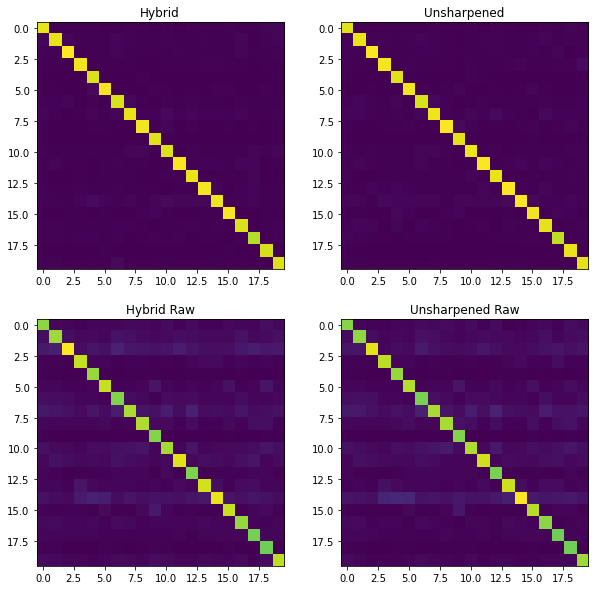

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(average_confusion_matrix_hybrid)
ax[0, 0].set_title("Hybrid")

ax[0, 1].imshow(average_confusion_matrix_unsharpened)
ax[0, 1].set_title("Unsharpened")

ax[1, 0].imshow(average_confusion_matrix_hybrid_raw)
ax[1, 0].set_title("Hybrid Raw")

ax[1, 1].imshow(average_confusion_matrix_unsharpened_raw)
ax[1, 1].set_title("Unsharpened Raw")


In [11]:
import seaborn as sns

def pretty_plot_heatmap(heatmap, labels, figsize_cm=(8,8)):
    # plot the heatmap with labels on the axes

    sns.set(context="paper", style="white", font_scale=1.5)

    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54)
        
    fig, ax = plt.subplots(figsize=figsize)


    im = ax.imshow(heatmap)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
            rotation_mode="anchor")
    
    ax.set_title("Confusion Matrix")
    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Percentage of residues captured (%)", rotation=-90, va="bottom")
    
    fig.tight_layout()
    
    return fig


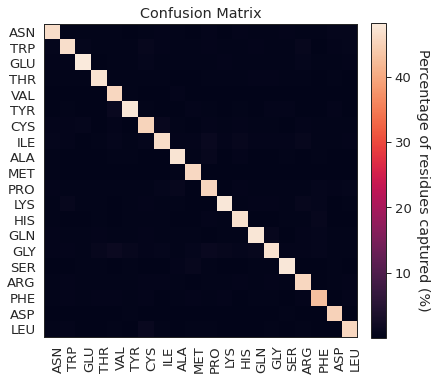

In [12]:
fig = pretty_plot_heatmap(average_confusion_matrix_hybrid, unique_hybrid_residue_list_names, figsize_cm=(16, 16))
#fig.savefig("confusion_matrix_hybrid.eps", dpi=600, bbox_inches="tight")

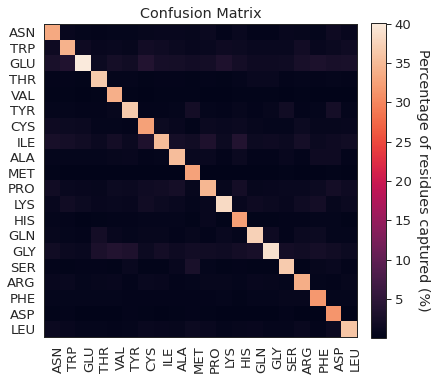

In [13]:
fig_raw = pretty_plot_heatmap(average_confusion_matrix_hybrid_raw, unique_hybrid_residue_list_names, figsize_cm=(16, 16))
#fig_raw.savefig("confusion_matrix_hybrid_raw.eps", dpi=600, bbox_inches="tight")

Text(15.892913385826773, 0.5, 'Reference')

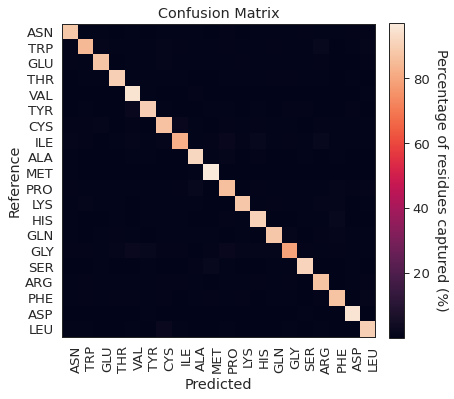

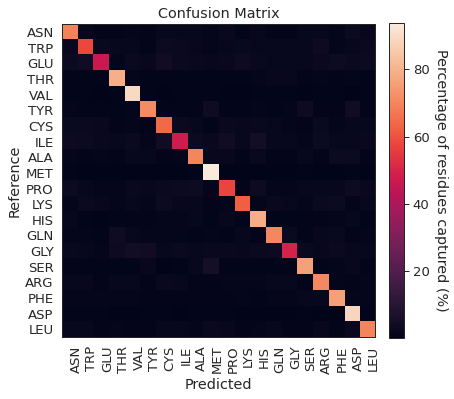

In [14]:
# Express the numbers in average_confusion_matrix_hybrid as percentages of each row
average_confusion_matrix_hybrid_percentages = np.zeros((len(unique_hybrid_residue_list_names), len(unique_hybrid_residue_list_names)))
average_confusion_matrix_hybrid_raw_percentages = np.zeros((len(unique_hybrid_residue_list_names), len(unique_hybrid_residue_list_names)))

for i in range(len(unique_hybrid_residue_list_names)):
    row_sum = np.sum(average_confusion_matrix_hybrid[i, :])
    row_sum_raw = np.sum(average_confusion_matrix_hybrid_raw[i, :])
    for j in range(len(unique_hybrid_residue_list_names)):
        average_confusion_matrix_hybrid_percentages[i, j] = average_confusion_matrix_hybrid[i, j] / row_sum
        average_confusion_matrix_hybrid_raw_percentages[i, j] = average_confusion_matrix_hybrid_raw[i, j] / row_sum_raw

fig = pretty_plot_heatmap(average_confusion_matrix_hybrid_percentages*100, unique_hybrid_residue_list_names, figsize_cm=(16, 16))
# add x label "predicted" and y label "reference"
fig.axes[0].set_xlabel("Predicted")
fig.axes[0].set_ylabel("Reference")
#fig.savefig("confusion_matrix_hybrid_percentages.eps", dpi=600, bbox_inches="tight")

fig_raw = pretty_plot_heatmap(average_confusion_matrix_hybrid_raw_percentages*100, unique_hybrid_residue_list_names, figsize_cm=(16, 16))
# add x label "predicted" and y label "reference"
fig_raw.axes[0].set_xlabel("Predicted")
fig_raw.axes[0].set_ylabel("Reference")
#fig_raw.savefig("confusion_matrix_hybrid_raw_percentages.eps", dpi=600, bbox_inches="tight")


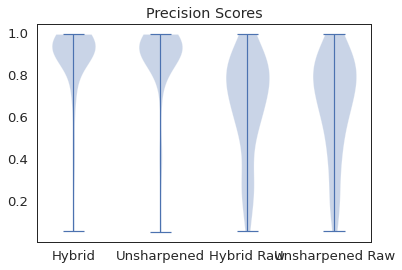

In [15]:
import seaborn as sns
precision_scores_hybrid = [x["hybrid"] for x in precision_dict.values() if x["hybrid"] is not None]
precision_scores_unsharpened = [x["unsharpened"] for x in precision_dict.values() if x["unsharpened"] is not None]
precision_scores_hybrid_raw = [x["hybrid_raw"] for x in precision_dict.values() if x["hybrid_raw"] is not None]
precision_scores_unsharpened_raw = [x["unsharpened_raw"] for x in precision_dict.values() if x["unsharpened_raw"] is not None]

recall_scores_hybrid = [x["hybrid"] for x in recall_dict.values() if x["hybrid"] is not None]
recall_scores_unsharpened = [x["unsharpened"] for x in recall_dict.values() if x["unsharpened"] is not None]
recall_scores_hybrid_raw = [x["hybrid_raw"] for x in recall_dict.values() if x["hybrid_raw"] is not None]
recall_scores_unsharpened_raw = [x["unsharpened_raw"] for x in recall_dict.values() if x["unsharpened_raw"] is not None]

plt.violinplot([precision_scores_hybrid, precision_scores_unsharpened, precision_scores_hybrid_raw, precision_scores_unsharpened_raw])
plt.xticks([1, 2, 3, 4], ["Hybrid", "Unsharpened", "Hybrid Raw", "Unsharpened Raw"])
plt.title("Precision Scores")
plt.show()


In [16]:
confusion_matrix_hybrid

array([[0.85      , 0.        , 0.        , 0.        , 0.        ,
        0.04347826, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.08333333, 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.04347826, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.93650794, 0.        , 0.        ,
        0.        , 0.05263158, 0.01136364, 0.        , 0.        ,
        0.02564103, 0.01      , 0.        , 0.03333333, 0.        ,
        0.        , 0.025     , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0